# Project 4: Kaggle Competition: West Nile Virus Prediction
### Notebook 04b: Preprocessing and Modeling (add in feature engineering data)

### Import required libraries

In [23]:
import pandas as pd
import requests

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from datetime import datetime

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score 
from sklearn.metrics import roc_auc_score, confusion_matrix, mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor

import random
from sklearn.utils import resample, shuffle
from IPython.display import Image

%matplotlib inline

#To visualize the whole grid
pd.options.display.max_columns = 999

# 1 Load and Importing Datasets

In [24]:
train = pd.read_csv('../csv_files/train_clean.csv')
test = pd.read_csv('../csv_files/test_clean.csv')
weather = pd.read_csv('../csv_files/weather_clean.csv')

# 2 Data Pre-processing

## 2.1 drop unwanted columns

#### Train, test datasets

In [25]:
### train test dataset

# drop the ID of test as it is not present in the train dataset and it is not needed
test.drop('Id', axis =1, inplace = True)

# drop the y-target, WnvPresent in train dataset
train.drop('WnvPresent', axis =1, inplace = True)

In [26]:
train.shape

(10506, 10)

In [27]:
test.shape

(116293, 10)

In [28]:
### Combine train and test datasets
combined = pd.concat([train, test])

print(f'Size of train/test dataset: {combined.shape}')

Size of train/test dataset: (126799, 10)


#### Weather dataset

In [29]:
# Drop Station 2 as most of the data from station 2 are actually duplicated form station 1

weather = weather.loc[weather['Station'] == 1].reset_index(drop = True)
weather.drop('Station', axis =1, inplace = True)
weather.head()

,Date,Tmax,Tmin,Tavg,Depart,DewPoint,WetBulb,Heat,Cool,Sunrise,Sunset,PrecipTotal,StnPressure,SeaLevel,ResultSpeed,ResultDir,AvgSpeed
0,2007-05-01,83,50,67,14,51,56.0,0,2,448,1849,0.0,29.10,29.82,1.7,27,9.2
1,2007-05-02,59,42,51,-3,42,47.0,14,0,447,1850,0.0,29.38,30.09,13.0,4,13.4
2,2007-05-03,66,46,56,2,40,48.0,9,0,446,1851,0.0,29.39,30.12,11.7,7,11.9
3,2007-05-04,66,49,58,4,41,50.0,7,0,444,1852,0.0,29.31,30.05,10.4,8,10.8
4,2007-05-05,66,53,60,5,38,49.0,5,0,443,1853,0.0,29.40,30.10,11.7,7,12.0


## 2.2 Combine train and weather datasets

In [30]:
### Change 'Date' data type to datetime

combined['Date'] = pd.to_datetime(combined.Date)
weather['Date'] = pd.to_datetime(weather.Date)


In [31]:
### Merge both datasets
all_dataset = combined.merge(weather, how = 'left', on = ['Date'])

print('Size of train/test dataset with weather data: {}'.format(all_dataset.shape))

Size of train/test dataset with weather data: (126799, 26)


## 2.3 Feature Engineering

### Interaction features

In [32]:
### Interaction features
all_dataset['tmax_precip'] = all_dataset['Tmax'] * all_dataset['PrecipTotal']
all_dataset['tmax_avgspeed'] = all_dataset['Tmax'] * all_dataset['AvgSpeed']
all_dataset['tmax_wetbulb'] = all_dataset['Tmax'] * all_dataset['WetBulb']

### Get Dummies for categorical variables

In [33]:
all_dataset = pd.get_dummies(all_dataset, columns = ['Species', 'Trap'])

In [34]:
print('Size of train/test dataset with weather data(One Hot Encoded): {}'.format(all_dataset.shape))

Size of train/test dataset with weather data(One Hot Encoded): (126799, 184)


### Split train and test dataset using year

In [35]:
### train dataset is with year in odd number (i.e. 2007, 2009, 2011, & 2013)
train = all_dataset.loc[all_dataset['year'] %2 !=0]
train.reset_index(inplace = True, drop = True)

In [36]:
### adding back the y-target on train dataset
df_train = pd.read_csv('../csv_files/train_clean.csv')
wnv = pd.Series(df_train['WnvPresent'])
train = pd.concat([train, wnv], axis =1)

In [37]:
### extract out the test dataset using year
test = all_dataset.loc[all_dataset['year'] %2 ==0]
print('Size of processed test data: {}'.format(test.shape))

Size of processed test data: (116293, 184)


### Compensating for imbalanced class

Out of the 10506 rows in our train dataset, only **551 (5.2%)** data points represent the virus present class (i.e. 1) while **9955 (94.8%)** represent virus not present (i.e. 0)

*94.8% will be the baseline accuracy for null model*

In [38]:
train['WnvPresent'].value_counts(normalize = True)

0    0.947554
1    0.052446
Name: WnvPresent, dtype: float64

In [39]:
#Splits data by presence of wnv
majority_class = train[train['WnvPresent']==0]
minority_class = train[train['WnvPresent']==1]

#Resamples minority class with replacement
minority_upsampled = resample(minority_class, 
                              replace=True, 
                              n_samples=majority_class.shape[0], 
                              random_state=42)

#Combine new minority class dataset with original majority class dataset
train_resampled = pd.concat([minority_upsampled,majority_class])

#Checks class representation
train_resampled.WnvPresent.value_counts()

1    9955
0    9955
Name: WnvPresent, dtype: int64

In [40]:
#Shuffles dataset to inject randomness
df = shuffle(train_resampled, random_state=42)
df.reset_index(drop=True, inplace=True)

#### Export train & test dataset 

In [41]:
df.to_csv('../csv_files/model_train_featuredata.csv', index = False)
test.to_csv('../csv_files/model_test_featuredata.csv', index = False)

## 2.4 Model Preparation
Create feature matrix (`X`) and target value (`y`)

The `WnvPresent` column is the target


In [42]:
X = df.drop(['Date','WnvPresent'], axis = 1)
y = df['WnvPresent']

In [43]:
### unlabeled test dataset
features = list(X.columns)
X_unlabeled = test[features]

### Train Test Split

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, shuffle = True, random_state=42 )

# 3 Modelling (Random Forest)

### Baseline Accuracy:

To recap, the dataset is highly imbalanced, as desribe in section 2.3. The naive baseline accuracy calculated to be **94.8%** (that is the null model is predicting the majority class). This is our baseline score.

On top of that, the cross_val_score obtained from Random Forest model using default hyperparameter (without optimization) give accuracy score of **94.9%**. 

These are our baseline accuracy score which we'll be able to evaluate either or not our modelling out-perform it or not.


In [45]:
### Create an instance of RandomForestClassifier

rf = RandomForestClassifier()

In [46]:
### Model Evaluation
### The accuracy achieved without any hyperparameter optimization is 95%

cross_val_score(rf, X_train, y_train, cv=5).mean()

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

0.949055977769301

In [47]:
### define the hyperparameters to be search in gridsearchcv
rf_params = {'n_estimators': [100, 500],
             'max_depth': [20, 25], 
             'min_samples_split': [2,4],
             'min_samples_leaf' : [1,2],
             'max_features' : [40, 50, 80]
             }

GridSearch to search for **optimum hyperparameters**

In [48]:
parameters = []
roc_auc = []

gs = GridSearchCV(estimator = RandomForestClassifier(),
                  param_grid = rf_params,
                  cv =3,
                  n_jobs = -1,
                  verbose =1,
                  return_train_score = True,
                  scoring = 'roc_auc'
                 )

gs.fit(X_train, y_train)

model = gs.best_estimator_
cv_score = gs.cv_results_
best_params = gs.best_params_

### predict y
y_pred = pd.DataFrame(model.predict_proba(X_test), columns = ['0', '1'])
y_pred2 = model.predict(X_test)

### print results
print("Best parameters:", best_params)
print("Best score:", gs.best_score_)
print("AUC/ROC test:", roc_auc_score(y_test, y_pred['1']))
pd.set_option('display.max_rows', 750)
display(pd.DataFrame(cv_score, columns = cv_score.keys()), )

### append info to list
parameters.append(best_params)
roc_auc.append(roc_auc_score(y_test,y_pred['1']))


Fitting 3 folds for each of 48 candidates, totalling 144 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done 144 out of 144 | elapsed: 20.7min finished


Best parameters: {'max_depth': 25, 'max_features': 50, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}
Best score: 0.9829140343149498
AUC/ROC test: 0.985363687836709


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,7.419137,0.044642,0.257638,0.003354,20,40,1,2,100,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.980595,0.978627,0.979189,0.979470,0.000828,24,0.991132,0.991017,0.991469,0.991206,0.000192
1,43.966145,0.419079,1.175079,0.084269,20,40,1,2,500,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.981263,0.979094,0.979018,0.979792,0.001041,20,0.991256,0.991122,0.991437,0.991272,0.000129
2,9.393235,1.583466,0.230202,0.012126,20,40,1,4,100,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.980527,0.977979,0.979259,0.979255,0.001040,28,0.990826,0.990513,0.991511,0.990950,0.000417
3,43.235924,0.498451,1.133759,0.020469,20,40,1,4,500,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.980508,0.978658,0.978683,0.979283,0.000866,27,0.991005,0.990990,0.991356,0.991117,0.000169
4,9.004421,1.423790,0.279858,0.070487,20,40,2,2,100,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.977572,0.971711,0.972691,0.973992,0.002563,48,0.988429,0.987828,0.988485,0.988247,0.000297
5,38.832769,0.273899,1.117559,0.113552,20,40,2,2,500,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.977873,0.971926,0.972533,0.974111,0.002672,45,0.988673,0.988054,0.988467,0.988398,0.000257
6,8.071560,0.866049,0.255854,0.052810,20,40,2,4,100,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.977017,0.972188,0.972986,0.974064,0.002113,46,0.988373,0.988020,0.988443,0.988278,0.000185
7,42.608998,0.215339,1.246702,0.174273,20,40,2,4,500,"{'max_depth': 20, 'max_features': 40, 'min_sam...",0.977321,0.972123,0.972637,0.974027,0.002339,47,0.988657,0.988104,0.988266,0.988342,0.000232
8,10.509484,2.026762,0.257690,0.016597,20,50,1,2,100,"{'max_depth': 20, 'max_features': 50, 'min_sam...",0.980499,0.979527,0.978701,0.979576,0.000735,23,0.991012,0.991332,0.991285,0.991210,0.000141
9,43.733031,0.325327,1.093083,0.013399,20,50,1,2,500,"{'max_depth': 20, 'max_features': 50, 'min_sam...",0.981022,0.979875,0.979367,0.980088,0.000692,18,0.991450,0.991673,0.991771,0.991631,0.000134


# 4 Model Evaluation

In [49]:
### Optimum hyperparameters from GridSearchCV
best_params

{'max_depth': 25,
 'max_features': 50,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 500}

In [50]:
### Accuracy and AUC_ROC scores from RandomForest modelling using optimum hyperparameters
print("Accuracy score:", round(gs.best_score_, 4))
print("Recall score:", round(recall_score(y_test, y_pred2),4 ))
print("AUC/ROC test:", roc_auc_score(y_test, y_pred['1'])) 


Accuracy score: 0.9829
Recall score: 0.9939
AUC/ROC test: 0.985363687836709


In [51]:
### Confusion matrix
cm = confusion_matrix(y_test, y_pred2)
tn, fp, fn, tp = cm.ravel()
pd.DataFrame(cm, columns = ['Predict neg', 'Predict pos'], index = ['Actual neg', 'Actual pos'])

,Predict neg,Predict pos
Actual neg,2658,340
Actual pos,18,2957


Metrics used to evaluate: **accuracy, recall, roc_auc**

The **recall** (sensitivity) is the ratio `tp / (tp + fn)`. The recall is intuitively the ability of the classifier to find all the positive samples, that is in this project, to predict WNV infected (WnvPresent = 1).

Thus, reducing fn is important as we would like to predict if there is WNV infection as accurately as possible.
fn means, predict there is NO WNV infection, but in actual case there WNV is present.

**AUC - ROC** curve on the other hand, is a performance measurement for classification problem at various thresholds settings. ROC is a probability curve and AUC represents degree or measure of separability. It tells how much model is capable of distinguishing between classes. In our case, the capability to distinguish WNV present (1) or NOT present (0). **Higher the AUC, better the model is at predicting between mosquitos with  WNV infection and no WNV infection.**

Results from Random Forest modeling (with optimum hyperparameter) shows that:
1. Accuracy score = 98.3% (better than baseline accuracy)
2. Recall score = 99.7% (confusion matrix shows that it has high tp (2965) and low fn (10)
3. AUC_ROC score = 98.5%

Which means, the model is able to **separate the WNV infection from no infection** quite well, and at the same time, have relatively **low fn** (low type II error).


### 4.1 Important Features (predictors) to predict y-target (WnvPresent)

Most of the TOP 20 important features predicted from the model are weather related. Location (indicated and longitude and latitude), as well as the mosquitos' species are crucial in detecting the WNV infection too.

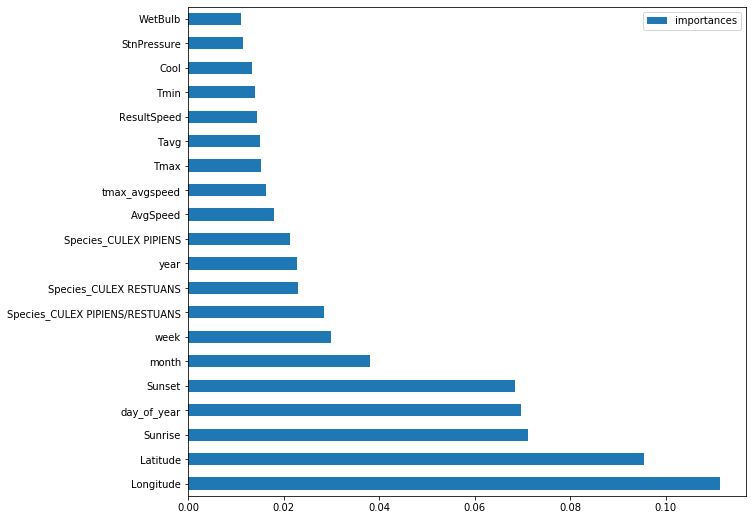

In [53]:
### visualise the TOP 20 features from the model
fi = pd.DataFrame({
    'features': X.columns,
    'importances': model.feature_importances_})
fig = fi.sort_values(by='importances', ascending=False).iloc[:20]
fig.plot(kind='barh', figsize=(10,9))
plt.yticks(range(len(fig)),fig['features'])
plt.show()

### 4.2 Predicts for unlabeled test dataset

In [54]:
### Prediction against unlabeled test dataset

pred = pd.DataFrame(model.predict_proba(X_unlabeled), columns=['0','1']) 

In [55]:
#Submission to Kaggle using the unlabeled test dataset

submission = pd.DataFrame()
submission['WnvPresent'] = pred['1']
submission['Id'] = submission.index + 1
submission[['Id', 'WnvPresent']].to_csv('../csv_files/submission_with_rf_pweather2.csv', index = False)

###  4.3 Total score from individual submissions

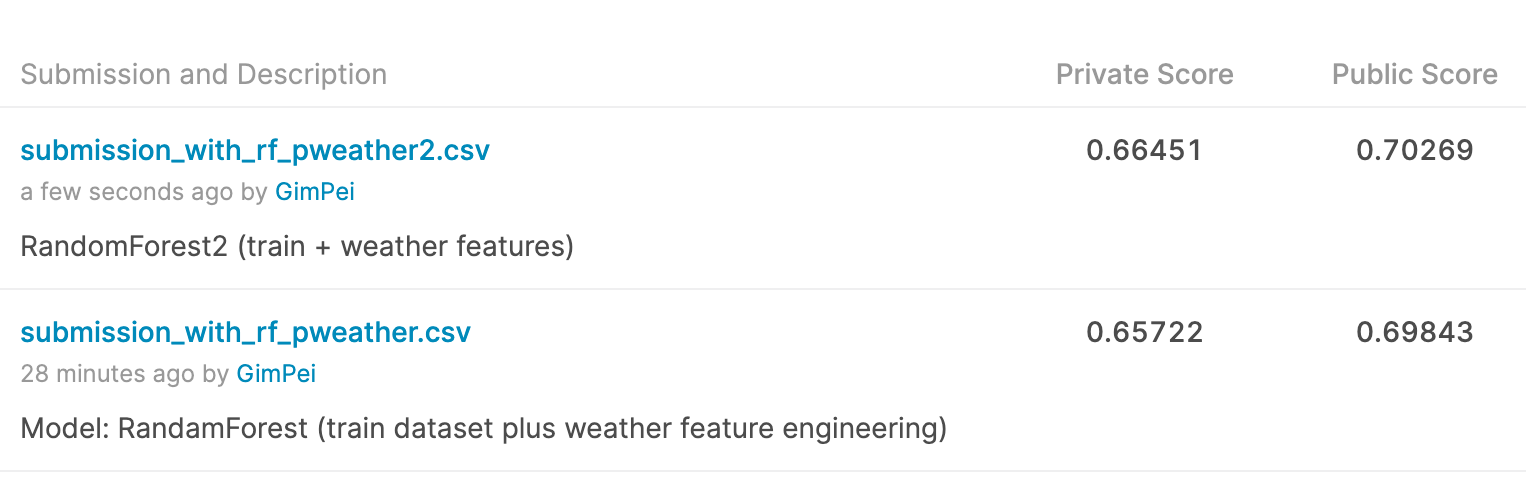

In [56]:
Image("../image/total_score_rf.png")

Among the models, **XGBoost** from previous modelling is having the highest Kaggle auc_roc's score on the un-labeled test dataset. Thus, our team propose to use this model for predicting the presence of WNV. 